AUTOMATIC ASSESSMENT OF PAVEMENT CONDITION  USING ROAD                                                           

# Problem Statement Description : Works constructed under the PMGSY scheme are to be maintained by the contractor as per the PMGSY guidelines. Pavement Condition Index is required to be performed to identify the road condition and further to take the maintenance or upgradation of the work. Through EMARG and PMGSY-III, NRIDA has collected a vast collection of pictures of roads. These pictures are collected while doing inspection of roads or collection of PCI through visual inspections. An AI assisted module would be able to automatically assess the picture and identify common issues such as shoulder clearance, potholes, road furniture etc. Requirement is of a solution where there should be a provision to capture the chainage wise pavement condition index. Use of open source software and existing neural network is encouraged. Train a machine learning model. which is able to identify common issues with pavement based on photograph(s) per road alone. Data Required: Yes (Annotated images to be released by NRIDA).


In this , we will build a classifier model from scratch that is able to assess the condition of road. We will follow these steps:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy

Let's go!

In [ ]:
import cv2 #to preprocess images(open cv)
import os #to access file directories
import numpy as np # to deal with multidimensional matrices
from random import shuffle 
from tqdm import tqdm
from sklearn.metrics import accuracy_score 
  
'''Setting up the env'''
  

IMG_SIZE = 150
LR = 1e-3

In [ ]:
base_dir = 'C:/Users/Govar/OneDrive/Desktop/sih_road_dataset_final'
train_good_dir = os.path.join(base_dir, 'good')
train_poor_dir = os.path.join(base_dir, 'poor')
train_satisfactory_dir = os.path.join(base_dir, 'satisfactory')
train_very_poor_dir = os.path.join(base_dir, 'very_poor')

In [ ]:
train_good_fnames = os.listdir(train_good_dir)
print(train_good_fnames[:20])
train_poor_fnames = os.listdir(train_poor_dir)
print(train_poor_fnames[:20])
train_satisfactory_fnames = os.listdir(train_satisfactory_dir)
print(train_satisfactory_fnames[:20])
train_very_poor_fnames = os.listdir(train_very_poor_dir)
print(train_very_poor_fnames[:20])


['good_001.JPG', 'good_002.JPG', 'good_003.JPG', 'good_004.JPG', 'good_005.JPG', 'good_006.JPG', 'good_007.JPG', 'good_008.JPG', 'good_009.JPG', 'good_010.JPG', 'good_011.JPG', 'good_012.JPG', 'good_013.JPG', 'good_014.JPG', 'good_015.JPG', 'good_016.JPG', 'good_017.JPG', 'good_018.JPG', 'good_019.JPG', 'good_020.JPG']
['poor_001.jpg', 'poor_002.jpg', 'poor_003.jpg', 'poor_004.jpg', 'poor_005.jpg', 'poor_006.jpg', 'poor_007.jpg', 'poor_008.jpg', 'poor_009.jpg', 'poor_010.jpg', 'poor_011.jpg', 'poor_012.jpg', 'poor_013.jpg', 'poor_014.jpg', 'poor_015.jpg', 'poor_016.jpg', 'poor_017.jpg', 'poor_018.jpg', 'poor_019.jpg', 'poor_020.jpg']
['satisfactory_001.jpg', 'satisfactory_002.jpg', 'satisfactory_003.jpg', 'satisfactory_004.jpg', 'satisfactory_005.jpg', 'satisfactory_006.jpg', 'satisfactory_007.jpg', 'satisfactory_008.jpg', 'satisfactory_009.jpg', 'satisfactory_010.jpg', 'satisfactory_011.jpg', 'satisfactory_012.jpg', 'satisfactory_013.jpg', 'satisfactory_014.jpg', 'satisfactory_015.jpg

In [ ]:
print('total training good images:', len(os.listdir(train_good_dir)))
print('total training bad images:', len(os.listdir(train_poor_dir)))
print('total training very bad images:', len(os.listdir(train_very_poor_dir)))
print('total training satisfactory images:', len(os.listdir(train_satisfactory_dir)))

total training good images: 845
total training bad images: 606
total training very bad images: 612
total training satisfactory images: 612


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

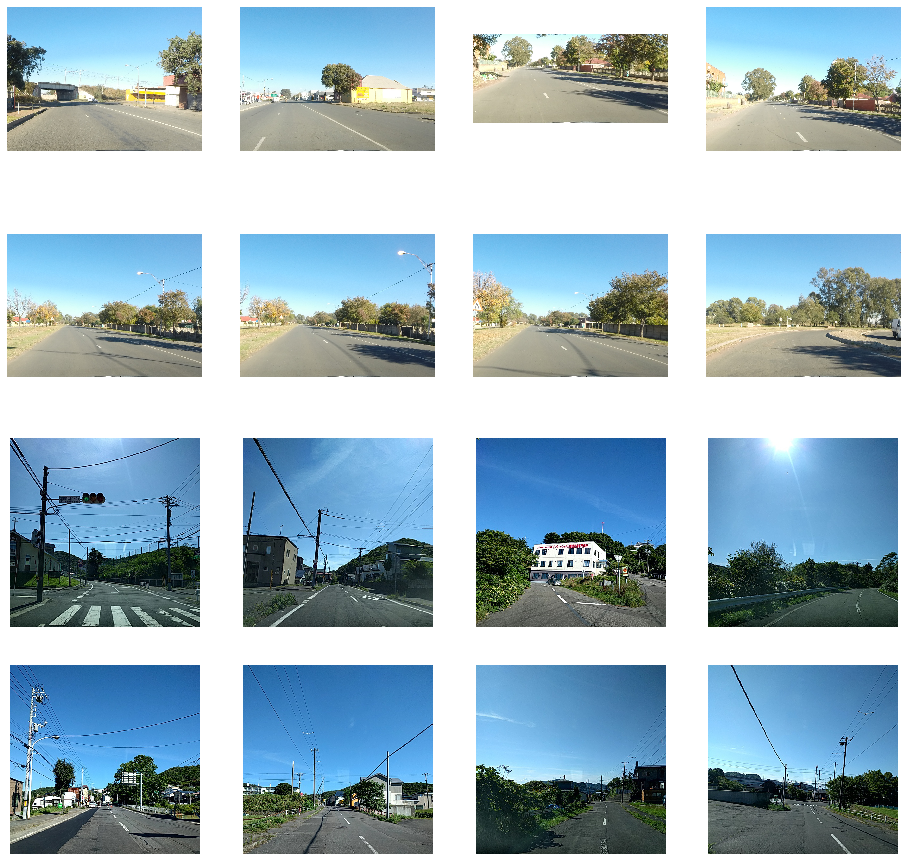

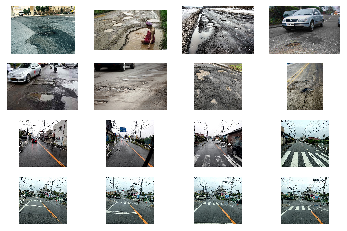

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_good_pix = [os.path.join(train_good_dir, fname) 
                for fname in train_good_fnames[pic_index-8:pic_index]]
next_satisfactory_pix = [os.path.join(train_satisfactory_dir, fname) 
                for fname in train_satisfactory_fnames[pic_index-8:pic_index]]
next_poor_pix = [os.path.join(train_poor_dir, fname) 
                for fname in train_poor_fnames[pic_index-8:pic_index]]
next_very_poor_pix = [os.path.join(train_very_poor_dir, fname) 
                for fname in train_very_poor_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_good_pix+next_poor_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()
for i, img_path in enumerate(next_very_poor_pix+next_satisfactory_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
def label_img(img): 
    word_label=img.split('_')[0]
    print(word_label)
    # DIY One hot encoder 
    if word_label == 'good':  return [1, 0,0,0] 
    elif word_label == 'poor': return [0, 1,0,0]
    elif word_label == 'satisfactory': return [0, 0,1,0] 
    elif word_label == 'verypoor': return [0, 0,0,1]  

In [ ]:
training_data=[]
# loading the training data 
def create_train_data(p): 
  
    for img in os.listdir(p): 
  
        try :
          label = label_img(img) 
  
          path = os.path.join(p, img) 
  
        # loading the image from the path and then converting them into 
        # greyscale for easier covnet prob 
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
  
        # resizing the image for processing them in the covnet 
          img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
  
        # final step-forming the training data list with numpy array of the images 
          training_data.append([np.array(img), np.array(label)]) 
        except :
           pass
    return training_data

In [ ]:
#g=create_train_data(train_good_dir)
#p=create_train_data(train_poor_dir)
#r=create_train_data()
for i in [train_good_dir,train_satisfactory_dir,train_very_poor_dir,train_poor_dir] :
    v=create_train_data(i)

good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good


In [ ]:
import random#shuffle(training_data) 
for i in range(100) :
    random.shuffle(training_data)

In [ ]:
t=np.array(training_data) #converting into numpy array

In [ ]:
np.shape(training_data)

(2673, 2)

In [ ]:
np.save('train_data.npy', training_data)  
#training_data = np.load('training_data.npy') 

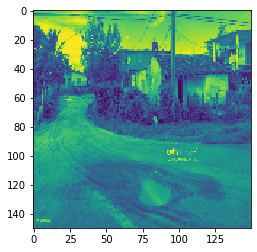

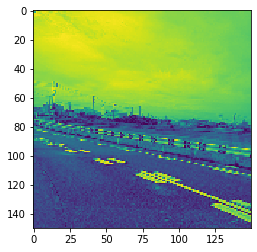

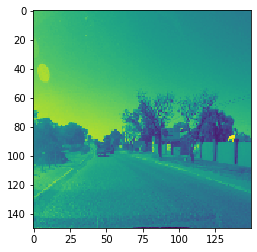

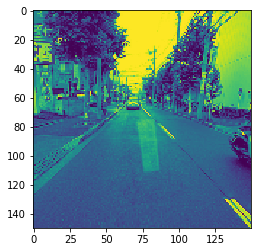

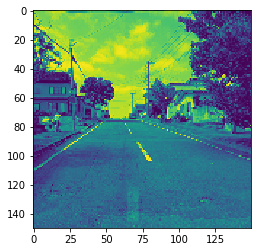

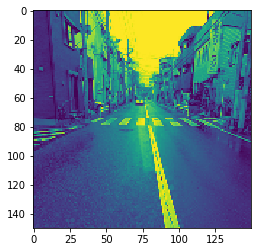

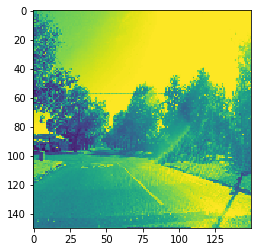

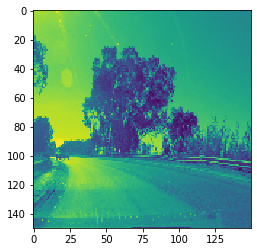

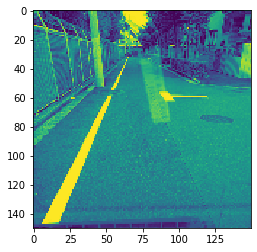

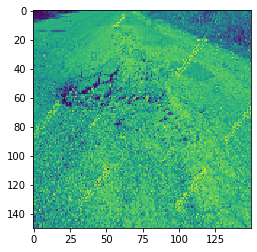

In [ ]:
for img in training_data[:10] :
    plt.imshow(img[0])
    plt.show()
    

In [ ]:
import tensorflow as tf 
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression 
  

In [ ]:
MODEL_NAME = 'Road_Pavement_Assessment'

In [ ]:
tf.reset_default_graph() 
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 4, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR, 
      loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_dir ='log') 
  

In [ ]:
X = np.array([i[0] for i in v]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
Y = [i[1] for i in v] 
  
'''Fitting the data into our model'''
# epoch = 5 taken 
model.fit({'input': X}, {'targets': Y}, n_epoch = 5)  
model.save(MODEL_NAME)

Training Step: 209  | total loss: 0.25439 | time: 50.809s
| Adam | epoch: 005 | loss: 0.25439 -- iter: 2624/2673
Training Step: 210  | total loss: 0.25301 | time: 52.059s
| Adam | epoch: 005 | loss: 0.25301 -- iter: 2673/2673
--
INFO:tensorflow:C:\Users\Govar\Downloads\Road_Pavement_Assessment is not in all_model_checkpoint_paths. Manually adding it.


In [ ]:
from sklearn.metrics import accuracy_score
y_predict=model.predict(X)
accuracy_score(np.argmax(Y,axis=1),np.argmax(y_predict,axis=1))*100 

93.4156378600823

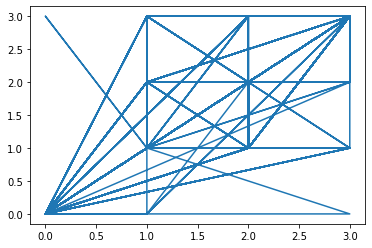

In [ ]:
plt.plot(np.argmax(Y,axis=1),np.argmax(y_predict,axis=1))

In [ ]:
for num, data in enumerate(training_data[:20]): 
    
       
    img_data = data[0] 
       
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 
   
    model_out = model.predict([data])[0]
    print(num,'--->',model_out,'--->',end=' ')
    test_class = np.argmax(model_out)
    test_class = test_class.tolist()
    labels=['good', 'poor','satisfactory','verypoor']
    print(labels[test_class])


0 ---> [6.3579914e-04 1.6090067e-02 8.9146765e-03 9.7435951e-01] ---> verypoor
1 ---> [0.00886704 0.37396187 0.58847183 0.02869924] ---> satisfactory
2 ---> [9.9660516e-01 3.5693630e-04 3.1190022e-04 2.7260284e-03] ---> good
3 ---> [4.7444322e-05 7.9216540e-02 9.1943687e-01 1.2991022e-03] ---> satisfactory
4 ---> [0.00088001 0.8651511  0.12614578 0.00782317] ---> poor
5 ---> [2.4113338e-04 8.9816429e-02 9.0593529e-01 4.0071462e-03] ---> satisfactory
6 ---> [9.9982917e-01 6.9133489e-06 8.2226470e-06 1.5560593e-04] ---> good
7 ---> [9.5424855e-01 5.2464195e-04 1.8045632e-04 4.5046449e-02] ---> good
8 ---> [5.1017367e-05 3.5972934e-02 9.6177709e-01 2.1989399e-03] ---> satisfactory
9 ---> [3.2296895e-05 1.6574177e-04 9.8907032e-05 9.9970299e-01] ---> verypoor
10 ---> [1.3364798e-04 2.5999187e-03 2.3383060e-03 9.9492812e-01] ---> verypoor
11 ---> [9.9991751e-01 1.8442042e-05 1.3427854e-05 5.0608869e-05] ---> good
12 ---> [9.9994063e-01 9.7064758e-06 5.8289061e-06 4.3767606e-05] ---> good
13

In [ ]:
def process_test_data(TEST_DIR): 
    testing_data = [] 
    try :
        for img in tqdm(os.listdir(TEST_DIR)): 
            path = os.path.join(TEST_DIR, img) 
        #img_num = img.split('.')[0] 
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
            testing_data.append([np.array(img)]) 
    except :
        img = cv2.imread(TEST_DIR, cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
        testing_data.append([np.array(img)]) 
        
          
    shuffle(testing_data) 
    #np.save('test_data.npy', testing_data) 
    return testing_data 

In [ ]:
import matplotlib.pyplot as plt 
# if you need to create the data: 
# test_data = process_test_data() 
# if you already have some saved: 
#test_data = np.load('test_data.npy') 
def predict(test_path) :
    fig = plt.figure() 
    testing_data=process_test_data(test_path)
    for num, data in enumerate(testing_data[:20]): 
        # cat: [1, 0] 
        # dog: [0, 1] 

        #img_num = data[1] 
        #img_data = data[0] 
        img_data = data[0] 

        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 

        model_out = model.predict([data])[0]
        #print(model_out)
        test_class = np.argmax(model_out)
        test_class = test_class.tolist()
        labels=['good', 'poor','satisfactory','verypoor']
        #print(labels[test_class])
        str_label=labels[test_class]


        y = fig.add_subplot(5, 6, num + 1) 
        orig = img_data
        #data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 

        # model_out = model.predict([data])[0] 
        #model_out = model.predict([data])[0] 

        #if np.argmax(model_out) == 1: str_label ='Dog'
        #else: str_label ='Cat'
        
        y.imshow(orig, cmap ='gray') 
        plt.title(str_label) 
        y.axes.get_xaxis().set_visible(False) 
        y.axes.get_yaxis().set_visible(False) 
    plt.show() 

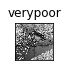

In [ ]:
predict('C:/Users/Govar/OneDrive/Desktop/test2.jpg')